## Import the libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import Callback
import keras.backend as K

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from lr_utils.keras_lr_finder import LRFinder
from lr_utils.keras_SGDR import SGDRScheduler
from lr_utils.keras_CLR import CyclicLR
from keras.callbacks import EarlyStopping

### Load the dataset

In [11]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

60000 train samples
10000 test samples


In [12]:
num_classes = 10
batch_size = 128

In [13]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

### Create a Network

The loss function has to be **categorical_crossentropy** since we deal with categorical labels.
The same goes for the last activation which has to be **softmax** since we have more than two classes (sigmoid would be fine for two classes).

In [14]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(784,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


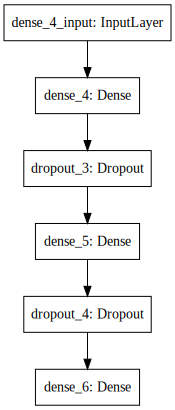

In [15]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

### Find the optimal Learning Rate

This method has been proposed by Leslie Smith. The concept to find the best learning rate is to begin at a small one, and increase it progressively. By looking at the loss function for the values of the Learning Rate, we can see it being very stable (no improvement) when the LR is small, then drop faster and faster and finally oscillate and diverge when the LR is too big. The optimal LR stands in the middle, where the slope is the steepest (not at the minimum of the curve).

In [16]:
lr_finder = LRFinder(min_lr=1e-5, max_lr=1e-2, steps_per_epoch=np.ceil(X_train.shape[0]/batch_size), epochs=1)
model.fit(X_train, y_train, callbacks=[lr_finder] )

Epoch 1/1
38496/60000 [==================>...........] - ETA: 9s - loss: 0.9724 - acc: 0.7751

Raw loss values

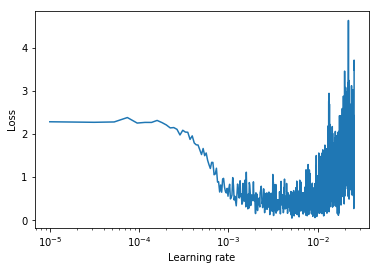

In [17]:
lr_finder.plot_loss()

Smoothed loss values. It is now easier to find the optimal learning rate

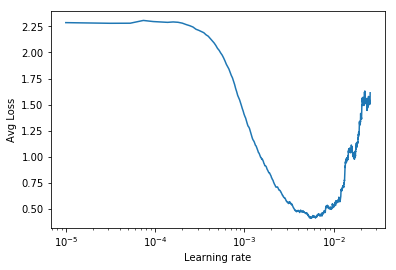

In [18]:
lr_finder.plot_avg_loss()

## Stochastic Gradient Descent with Restart (SGDR)

In [10]:
schedule = SGDRScheduler(min_lr=1e-4,max_lr=1e-3,steps_per_epoch=np.ceil(X_train.shape[0]/batch_size), lr_decay=0.9, cycle_length=3,mult_factor=1.5)
model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test), callbacks=[schedule])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 10s 165us/step - loss: 0.4421 - acc: 0.9030 - val_loss: 0.2467 - val_acc: 0.9422
Epoch 2/10
60000/60000 [==============================] - 9s 155us/step - loss: 0.3167 - acc: 0.9261 - val_loss: 0.2216 - val_acc: 0.9494
Epoch 3/10
60000/60000 [==============================] - 10s 159us/step - loss: 0.2895 - acc: 0.9305 - val_loss: 0.2118 - val_acc: 0.9511
Epoch 4/10
60000/60000 [==============================] - 9s 157us/step - loss: 0.2686 - acc: 0.9351 - val_loss: 0.1835 - val_acc: 0.9555
Epoch 5/10
60000/60000 [==============================] - 9s 157us/step - loss: 0.2250 - acc: 0.9425 - val_loss: 0.1668 - val_acc: 0.9605
Epoch 6/10
60000/60000 [==============================] - 9s 158us/step - loss: 0.2032 - acc: 0.9482 - val_loss: 0.1573 - val_acc: 0.9637
Epoch 7/10
60000/60000 [==============================] - 9s 156us/step - loss: 0.1865 - acc: 0.9500 - val_loss: 0.1514 

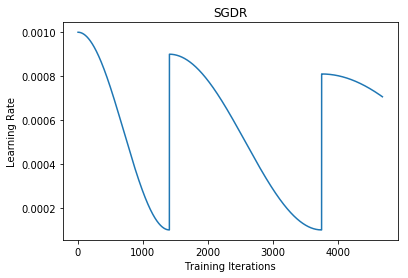

In [11]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("SGDR")
plt.plot(schedule.history['iterations'], schedule.history['lr'])

In [12]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.149040305674
Test accuracy: 0.9649


## Cyclical Learning Rate (CLR)

In [13]:
clr_triangular = CyclicLR(mode='triangular', step_size=np.ceil(X_train.shape[0]/batch_size))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
model.fit(X_train, y_train, batch_size=128, epochs=10, validation_data=(X_test, y_test), callbacks=[clr_triangular])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 9s 157us/step - loss: 0.2283 - acc: 0.9437 - val_loss: 0.2168 - val_acc: 0.9527
Epoch 2/10
60000/60000 [==============================] - 9s 155us/step - loss: 0.2321 - acc: 0.9442 - val_loss: 0.1250 - val_acc: 0.9701
Epoch 3/10
60000/60000 [==============================] - 9s 157us/step - loss: 0.1699 - acc: 0.9563 - val_loss: 0.1628 - val_acc: 0.9583
Epoch 4/10
60000/60000 [==============================] - 9s 158us/step - loss: 0.1809 - acc: 0.9544 - val_loss: 0.1105 - val_acc: 0.9729
Epoch 5/10
60000/60000 [==============================] - 9s 157us/step - loss: 0.1408 - acc: 0.9637 - val_loss: 0.1570 - val_acc: 0.9627
Epoch 6/10
60000/60000 [==============================] - 9s 157us/step - loss: 0.1701 - acc: 0.9575 - val_loss: 0.1161 - val_acc: 0.9724
Epoch 7/10
60000/60000 [==============================] - 9s 157us/step - loss: 0.1312 - acc: 0.9660 - val_loss: 0.1543 - 

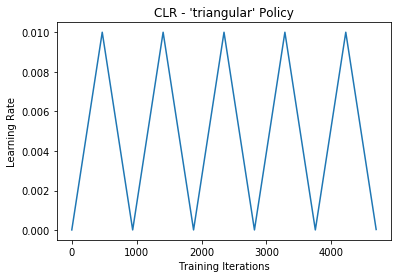

In [15]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - 'triangular' Policy")
plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])

In [16]:
clr_triangular = CyclicLR(mode='triangular2', step_size=np.ceil(X_train.shape[0]/batch_size))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
model.fit(X_train, y_train, batch_size=128, epochs=10, validation_data= (X_test, y_test), callbacks=[clr_triangular])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 10s 160us/step - loss: 0.1353 - acc: 0.9678 - val_loss: 0.1668 - val_acc: 0.9626
Epoch 2/10
60000/60000 [==============================] - 10s 159us/step - loss: 0.1595 - acc: 0.9635 - val_loss: 0.1201 - val_acc: 0.9736
Epoch 3/10
60000/60000 [==============================] - 10s 159us/step - loss: 0.1010 - acc: 0.9746 - val_loss: 0.1361 - val_acc: 0.9702
Epoch 4/10
60000/60000 [==============================] - 10s 160us/step - loss: 0.0956 - acc: 0.9761 - val_loss: 0.1023 - val_acc: 0.9776
Epoch 5/10
60000/60000 [==============================] - 10s 160us/step - loss: 0.0746 - acc: 0.9808 - val_loss: 0.1086 - val_acc: 0.9761
Epoch 6/10
60000/60000 [==============================] - 10s 160us/step - loss: 0.0706 - acc: 0.9818 - val_loss: 0.1063 - val_acc: 0.9784
Epoch 7/10
60000/60000 [==============================] - 10s 159us/step - loss: 0.0616 - acc: 0.9835 - val_loss: 0.

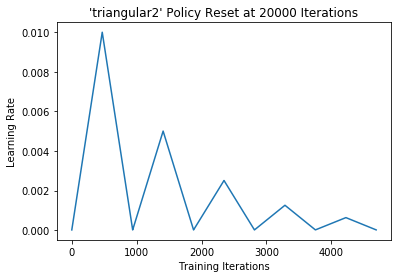

In [18]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("'triangular2' Policy Reset at 20000 Iterations")
plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])

In [19]:
clr_triangular._reset()

In [20]:
model.fit(X_train, y_train, batch_size=128, epochs=10, validation_data=(X_test, y_test), callbacks=[clr_triangular])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 10s 160us/step - loss: 0.1205 - acc: 0.9735 - val_loss: 0.2254 - val_acc: 0.9611
Epoch 2/10
60000/60000 [==============================] - 10s 159us/step - loss: 0.2474 - acc: 0.9510 - val_loss: 0.1490 - val_acc: 0.9699
Epoch 3/10
60000/60000 [==============================] - 10s 160us/step - loss: 0.1248 - acc: 0.9708 - val_loss: 0.1467 - val_acc: 0.9715
Epoch 4/10
60000/60000 [==============================] - 10s 159us/step - loss: 0.1138 - acc: 0.9739 - val_loss: 0.1150 - val_acc: 0.9762
Epoch 5/10
60000/60000 [==============================] - 10s 160us/step - loss: 0.0825 - acc: 0.9793 - val_loss: 0.1136 - val_acc: 0.9766
Epoch 6/10
60000/60000 [==============================] - 10s 160us/step - loss: 0.0766 - acc: 0.9804 - val_loss: 0.1132 - val_acc: 0.9759
Epoch 7/10
60000/60000 [==============================] - 10s 159us/step - loss: 0.0711 - acc: 0.9824 - val_loss: 0.

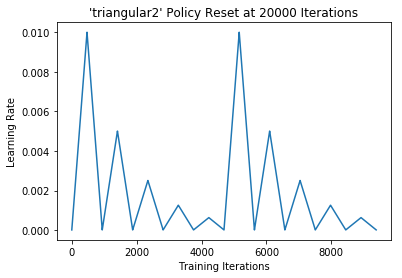

In [21]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("'triangular2' Policy Reset at 20000 Iterations")
plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])

In [22]:
clr_triangular = CyclicLR(mode='exp_range', step_size=np.ceil(X_train.shape[0]/batch_size), gamma=0.9994)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
model.fit(X_train, y_train, batch_size=128, epochs=10, validation_data=(X_test, y_test), callbacks=[clr_triangular])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 10s 168us/step - loss: 0.0912 - acc: 0.9781 - val_loss: 0.1623 - val_acc: 0.9706
Epoch 2/10
60000/60000 [==============================] - 10s 159us/step - loss: 0.1049 - acc: 0.9763 - val_loss: 0.1222 - val_acc: 0.9771
Epoch 3/10
60000/60000 [==============================] - 10s 159us/step - loss: 0.0735 - acc: 0.9816 - val_loss: 0.1361 - val_acc: 0.9750
Epoch 4/10
60000/60000 [==============================] - 10s 159us/step - loss: 0.0758 - acc: 0.9814 - val_loss: 0.1103 - val_acc: 0.9778
Epoch 5/10
60000/60000 [==============================] - 10s 159us/step - loss: 0.0602 - acc: 0.9847 - val_loss: 0.1192 - val_acc: 0.9786
Epoch 6/10
60000/60000 [==============================] - 10s 159us/step - loss: 0.0587 - acc: 0.9845 - val_loss: 0.1102 - val_acc: 0.9797
Epoch 7/10
60000/60000 [==============================] - 10s 160us/step - loss: 0.0496 - acc: 0.9872 - val_loss: 0.

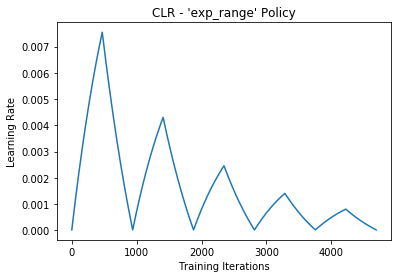

In [24]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - 'exp_range' Policy")
plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])

In [25]:
clr_triangular._reset(new_base_lr=0.003, new_step_size=np.ceil(X_train.shape[0]/batch_size), new_max_lr=0.009)

In [26]:
model.fit(X_train, y_train, batch_size=128, epochs=10, validation_data=(X_test, y_test), callbacks=[clr_triangular])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 10s 161us/step - loss: 0.1132 - acc: 0.9752 - val_loss: 0.1731 - val_acc: 0.9685
Epoch 2/10
60000/60000 [==============================] - 10s 161us/step - loss: 0.1447 - acc: 0.9690 - val_loss: 0.1257 - val_acc: 0.9774
Epoch 3/10
60000/60000 [==============================] - 10s 162us/step - loss: 0.0855 - acc: 0.9787 - val_loss: 0.1174 - val_acc: 0.9778
Epoch 4/10
60000/60000 [==============================] - 9s 158us/step - loss: 0.0825 - acc: 0.9800 - val_loss: 0.1154 - val_acc: 0.9775
Epoch 5/10
60000/60000 [==============================] - 9s 158us/step - loss: 0.0708 - acc: 0.9824 - val_loss: 0.1243 - val_acc: 0.9769
Epoch 6/10
60000/60000 [==============================] - 10s 158us/step - loss: 0.0763 - acc: 0.9817 - val_loss: 0.1128 - val_acc: 0.9783
Epoch 7/10
60000/60000 [==============================] - 10s 161us/step - loss: 0.0627 - acc: 0.9837 - val_loss: 0.12

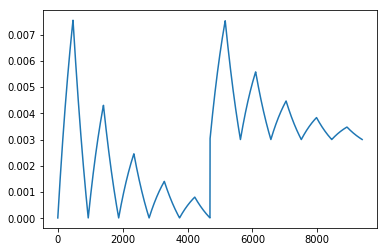

In [27]:
plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])

In [28]:
clr = lambda x: 0.5*(1+np.sin(x*np.pi/2.))

In [29]:
clr_triangular = CyclicLR(scale_fn=clr, scale_mode='cycle', step_size=np.ceil(X_train.shape[0]/batch_size))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
model.fit(X_train, y_train, batch_size=128, epochs=10, validation_data=(X_test, y_test), callbacks=[clr_triangular])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 9s 158us/step - loss: 0.0793 - acc: 0.9824 - val_loss: 0.1891 - val_acc: 0.9683
Epoch 2/10
60000/60000 [==============================] - 9s 157us/step - loss: 0.1474 - acc: 0.9707 - val_loss: 0.1252 - val_acc: 0.9764
Epoch 3/10
60000/60000 [==============================] - 9s 157us/step - loss: 0.0828 - acc: 0.9814 - val_loss: 0.1637 - val_acc: 0.9760
Epoch 4/10
60000/60000 [==============================] - 9s 156us/step - loss: 0.0777 - acc: 0.9827 - val_loss: 0.1341 - val_acc: 0.9800
Epoch 5/10
60000/60000 [==============================] - 9s 157us/step - loss: 0.0604 - acc: 0.9864 - val_loss: 0.1339 - val_acc: 0.9801
Epoch 6/10
60000/60000 [==============================] - 9s 157us/step - loss: 0.0576 - acc: 0.9864 - val_loss: 0.1337 - val_acc: 0.9800
Epoch 7/10
60000/60000 [==============================] - 9s 156us/step - loss: 0.0610 - acc: 0.9856 - val_loss: 0.1266 - 

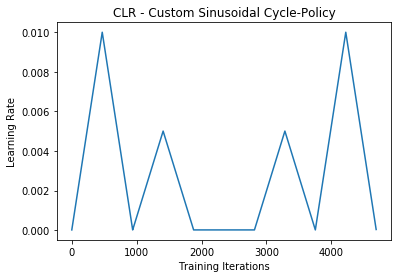

In [31]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - Custom Sinusoidal Cycle-Policy")
plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])

In [32]:
clr = lambda x: 1/(5**(x*0.0001))

In [33]:
clr_triangular = CyclicLR(scale_fn=clr, scale_mode='iterations', step_size=np.ceil(X_train.shape[0]/batch_size))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
model.fit(X_train, y_train, batch_size=128, epochs=10, validation_data=(X_test, y_test), callbacks=[clr_triangular])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 10s 159us/step - loss: 0.1319 - acc: 0.9733 - val_loss: 0.2038 - val_acc: 0.9695
Epoch 2/10
60000/60000 [==============================] - 9s 157us/step - loss: 0.1326 - acc: 0.9731 - val_loss: 0.1458 - val_acc: 0.9751
Epoch 3/10
60000/60000 [==============================] - 9s 157us/step - loss: 0.0902 - acc: 0.9800 - val_loss: 0.1846 - val_acc: 0.9709
Epoch 4/10
60000/60000 [==============================] - 9s 158us/step - loss: 0.1127 - acc: 0.9772 - val_loss: 0.1334 - val_acc: 0.9783
Epoch 5/10
60000/60000 [==============================] - 10s 160us/step - loss: 0.0860 - acc: 0.9794 - val_loss: 0.1398 - val_acc: 0.9784
Epoch 6/10
60000/60000 [==============================] - 10s 160us/step - loss: 0.0905 - acc: 0.9804 - val_loss: 0.1285 - val_acc: 0.9785
Epoch 7/10
60000/60000 [==============================] - 9s 157us/step - loss: 0.0681 - acc: 0.9836 - val_loss: 0.1533

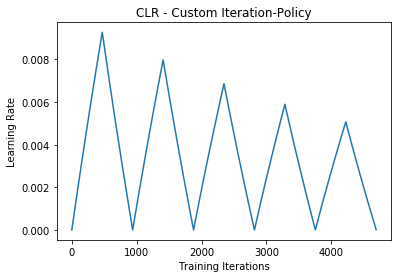

In [35]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - Custom Iteration-Policy")
plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])